In [183]:
import numpy as np
import matplotlib.pyplot as plt
import pylab
import numpy as np
import scipy.io
import scipy.stats
import datetime
import os
import pandas as pd
import matplotlib as mpl
import math

%matplotlib inline
from scipy.stats import stats
from IPython.display import display
from glob import glob
from sklearn.metrics import roc_curve, auc
from sklearn.linear_model import LogisticRegression
#from sklearn.linear_model import RandomizedLogisticRegression
from sklearn.metrics import classification_report
from sklearn.calibration import calibration_curve

## Load data with features

In [66]:
# Import One codex CSV file as pd dataframe, transpose to make sample name as index
Origin_df = pd.read_csv('/Users/liyixu/20170625DonorPatientPre_features.csv')
Mid_df = Origin_df.T
Mid_df.columns = Mid_df.iloc[0]
df = Mid_df.drop(Mid_df.index[0]) 
# Sum and combine the columns with the same phylum name
X_df = df.groupby(df.columns, axis =1).sum()

##    Load donor results

In [4]:
Y_df = pd.read_csv('./DonorPatientPre_Results.csv', header = 0)
Y_df = Y_df.dropna(axis = 0)
Y_df.columns = ['Sample Name','Results','Probability']
Y_df.set_index ('Sample Name', inplace=True)
Y_df.index.name = None

### Make pie charts to compare succesful and failed donors

In [68]:
# calculate percentage composition
PercentCompos_Success = X_df[Y_df['Results'] == 1].div((X_df[Y_df['Results'] == 1].sum(axis = 1)),axis = 0)
Average_PercentCompos_Success = PercentCompos_Success.mean(axis = 0)
PercentCompos_Fail = X_df[Y_df['Results'] == 0].div((X_df[Y_df['Results'] == 0].sum(axis = 1)),axis = 0)
Average_PercentCompos_Fail = PercentCompos_Fail.mean(axis=0)

X_dfpercent = X_df.div(X_df.sum(axis = 1),axis = 0)

# Sort compositions from largest to smallest
Sorted_Average_Success = Average_PercentCompos_Success.sort_values(ascending=False).to_frame()
Sorted_Average_Fail = Average_PercentCompos_Fail.sort_values(ascending=False).to_frame()

# Pick out one example as illustration
SortedOneSample = X_df.loc['SRR5318456_90000_1.fastq.gz'].sort_values(ascending=False).to_frame()

# Compare the one example to average success and average failure donors 
OneSample_vs_AverageSuccess = pd.concat([SortedOneSample,Sorted_Average_Success],axis = 1, join_axes = [SortedOneSample.index],keys = ['One Sample', 'Average Success'])
OneSample_vs_AverageFailure = pd.concat([SortedOneSample,Sorted_Average_Fail],axis = 1, join_axes = [SortedOneSample.index],keys = ['One Sample', 'Average Fail'])

In [69]:
# Clean up the column name and join top 10 phyla by index 
Sorted_Average_Success.index.name = None
#Sorted_Average_Success.columns =  ['Results']
Sorted_Average_Fail.index.name = None
#Sorted_Average_Fail.columns =  ['Results']
AverageSuccess_vs_AverageFailure = pd.concat([Sorted_Average_Success,Sorted_Average_Fail],axis=1, join_axes=[Sorted_Average_Success.index])
AverageSuccess_vs_AverageFailure.columns = ['Success', 'Failure']

In [70]:
Piechart=AverageSuccess_vs_AverageFailure[0:6]*100
Piechart.loc["Others"]=AverageSuccess_vs_AverageFailure[6:].sum(axis=0)*100

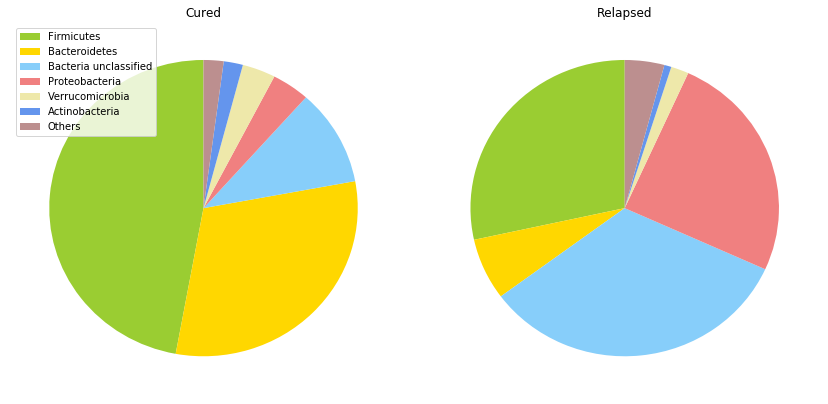

In [71]:
# Plot average success and failure comparisions in microbial composition as pie charts
labels = Piechart.index.values
sizes_success = Piechart["Success"].values
sizes_failure = Piechart["Failure"].values
colors = ['yellowgreen', 'gold', 'lightskyblue', 'lightcoral','palegoldenrod','cornflowerblue','rosybrown']
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
ax1.pie(sizes_success, colors=colors, shadow=False, startangle=90)
ax2.pie(sizes_failure, colors=colors, shadow=False, startangle=90)
ax1.set_title('Cured')
ax1.legend(labels)
ax2.set_title('Relapsed')
f.tight_layout()
f.set_size_inches(12,6,forward=True)
plt.show()
# horizontal bar charts history
# plt.figure();
# ax = AverageSuccess_vs_AverageFailure[0:10].plot.barh();
# ax.set_xscale('log')
# ax.set_xlabel('Average percentage composition',fontsize='18')
# plt.yticks(fontsize='18')
# fig=plt.gcf()
# fig.set_size_inches(10,10,forward=True)
# fig.savefig('AveragePercentageComposition.jpg', bbox_inches='tight')
# plt.show()

## Calculate alpha shannon diversity as a new feature

In [72]:
import skbio.diversity
from skbio.diversity import alpha
from skbio.diversity import beta
X_df['AlphaDiversity']="0"
for lines in enumerate(X_df.iterrows()):
    X_df['AlphaDiversity'].iloc[lines[0]]=skbio.diversity.alpha.shannon(X_df.iloc[lines[0]].astype(int))

In [73]:
#Normalize the alpha diversity column (x-xmin)(xmax-xmin)
DiversityRange=max(X_df['AlphaDiversity'].values)-min(X_df['AlphaDiversity'].values)
X_dfpercent['AlphaDiversity']="0"
for lines in enumerate(X_dfpercent.iterrows()):
    X_dfpercent['AlphaDiversity'].iloc[lines[0]]=(X_df['AlphaDiversity'].iloc[lines[0]]-min(X_df['AlphaDiversity'].values))/DiversityRange

## Save the modified dataframes

In [94]:
X_dfpercent.to_csv('./20170625DonorPatientPre_features.csv')
Y_df.to_csv('./20170625DonorPatientPre_results.csv')

## Use logistic regression to train and test the dataset, with test size=0.5

In [96]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_dfpercent
                                                    , Y_df
                                                    , test_size=0.5
                                                    , random_state=42)
lr = LogisticRegression()
model = lr.fit (X_train, y_train['Results'].values)
preds = lr.predict (X_test)
report = classification_report (y_test['Results'], preds)
print(report)
print "Score:", model.score(X_test, y_test['Results'])

             precision    recall  f1-score   support

        0.0       1.00      0.64      0.78        14
        1.0       0.74      1.00      0.85        14

avg / total       0.87      0.82      0.82        28

Score: 0.821428571429


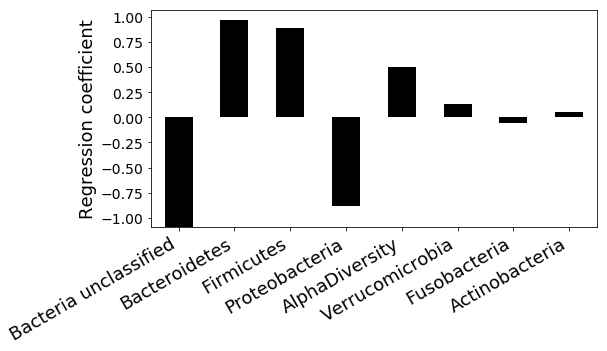

In [97]:
#Calculate coefficient of features 
Coeff = pd.DataFrame(data=model.coef_, columns=list(X_train.columns.values), index=['Coeff'])
Coeff_T = Coeff.transpose()
Coeff_TF = Coeff_T.reindex(Coeff_T.Coeff.abs().sort_values(ascending=False).index)
# Coeff.loc['0'].sort_values(ascending=False,inplace=True)
plt.figure();
# ax1=plt.bar(list(X_train.columns.values),list(model.coef_[0]))
Coeff_TF[0:8].plot.bar(logy=False,color='k',legend=None)
plt.xticks(rotation=30,horizontalalignment='right',fontsize=18)
plt.yticks(fontsize=14)
plt.ylabel('Regression coefficient', fontsize='18')
fig = plt.gcf()
fig.set_size_inches(8,4,forward=True)
plt.show()

In [98]:
# see the difference of train data vesus test data accuracy, to check whether they are similar 
print "Score:", model.score(X_train, y_train['Results'])
probas_ = lr.fit(X_train, y_train['Results'].values).predict_proba(X_dfpercent)
Y_df['Probability']=probas_[:,1]

Score: 0.857142857143


## PCA plots

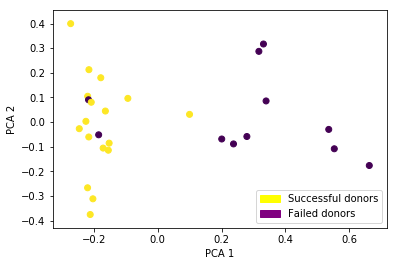

In [99]:
import matplotlib.patches as mpatches
from sklearn import decomposition
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D
pca=PCA(n_components=2)
pca.fit(X_train)
X=pca.transform(X_train)
yellow_patch = mpatches.Patch(color = 'yellow', label = 'Successful donors')
purple_patch = mpatches.Patch(color = 'purple', label = 'Failed donors')
plt.scatter (X[:,0],X[:,1], c=y_train['Results'])
plt.legend([yellow_patch,purple_patch],['Successful donors', 'Failed donors'])
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.show()

## Calculate ROC and auc of ROC

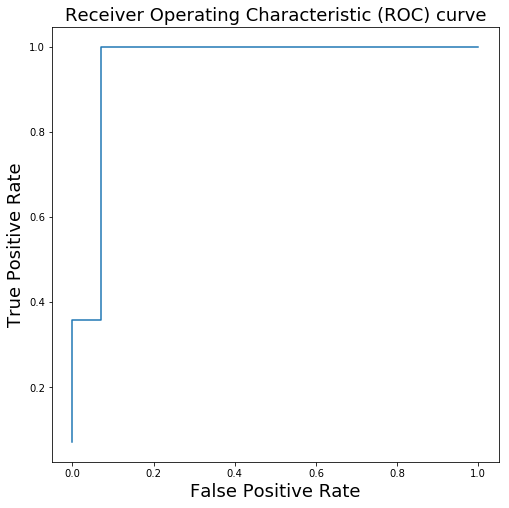

AUC of ROC curve is: 0.954081632653


In [100]:
#http://scikit-learn.org/stable/auto_examples/model_selection/plot_roc_crossval.html#sphx-glr-auto-examples-model-selection-plot-roc-crossval-py
# Make ROC curve from probability data 
probas_ = lr.fit(X_train, y_train['Results'].values).predict_proba(X_test)
fpr, tpr, thresholds = roc_curve(y_test['Results'], probas_ [:,1])
#fig, ax = plt.subplots()
plt.plot(fpr, tpr)
# ax.set_xlim([0,1])
# ax.set_ylim([0,1])
plt.xlabel('False Positive Rate',fontsize='18')
plt.ylabel('True Positive Rate',fontsize='18')
plt.title('Receiver Operating Characteristic (ROC) curve',fontsize='18')
fig = plt.gcf()
fig.set_size_inches(8,8,forward=True)
plt.show()  # chose threshold = 0.8 to minimize false positive rate 

roc_auc=auc(fpr,tpr)
print "AUC of ROC curve is:", roc_auc

In [102]:
thresholds

array([ 0.72788935,  0.71105545,  0.71036759,  0.68325596,  0.40510779])

In [101]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test['Results'], preds)

array([[ 9,  5],
       [ 0, 14]])

## Implement LeaveOneOut for logistic regression

In [103]:
from sklearn.model_selection import LeaveOneOut 
loo = LeaveOneOut()
loo.get_n_splits(X_dfpercent)
accuracy=[]
AverageAccuracy=[]
for train_index, test_index in loo.split(X_dfpercent):
    #print ("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X_dfpercent.iloc[train_index], X_dfpercent.iloc[test_index]
    y_train, y_test = Y_df.iloc[train_index], Y_df.iloc[test_index]
    lr = LogisticRegression()
    model = lr.fit (X_train, y_train['Results'].values)
    preds = lr.predict (X_test)
    accuracy.append(model.score(X_test, y_test['Results']))
AverageAccuracy=sum(accuracy)/len(accuracy)
#     StdAccuracy=list(accuracy).std
print "Average accuracy Score is" , AverageAccuracy
print "Standard deviation is", np.std(accuracy)

Average accuracy Score is 0.892857142857
Standard deviation is 0.309294787066


In [368]:
accuracy


[1.0,
 1.0,
 0.0,
 1.0,
 1.0,
 0.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.0,
 0.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0]

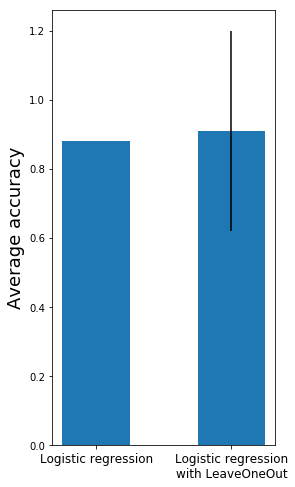

In [104]:
# compare the accuracy with only logistic regression
xlocation = (1.1,1.4)
accu_mean = (0.88, 0.91)
accu_std = (0, 0.29)
plt.bar(xlocation,accu_mean, 0.15, yerr=accu_std )
plt.xticks(xlocation, ('Logistic regression', 'Logistic regression\nwith LeaveOneOut'),fontsize='12')
plt.ylabel('Average accuracy',fontsize='18')
fig = plt.gcf()
fig.set_size_inches(4,8,forward=True)

## L1-based feature selection


In [105]:
from sklearn import linear_model
from sklearn.svm import LinearSVC
from sklearn.linear_model import LassoCV
from sklearn.metrics import r2_score
from sklearn.feature_selection import SelectFromModel
lsvc = LinearSVC(C=0.15, penalty="l1", dual=False).fit(X_dfpercent, Y_df['Results'])
model = SelectFromModel(lsvc, prefit=True)
X_new = model.transform(X_dfpercent)
X_new.shape

(56, 4)

In [106]:
# Lasso cross validation 
clf = LassoCV()
sfm = SelectFromModel(clf, threshold=0.1)
sfm.fit(X_train, y_train['Results'])
n_features = sfm.transform(X_train).shape[1]
print n_features

7


## Making interative plots

In [362]:
# Make bokeh plot showing bobbles of microbes 
from bokeh.io import push_notebook, show, output_notebook
from bokeh.plotting import figure, output_file, show
#from bokeh.charts import Bar, Donut
# from bokeh.palettes import brewer, Spectral6
from bokeh.models import HoverTool
from bokeh.plotting import ColumnDataSource
import matplotlib
colors=[]
p = figure(
    plot_width = 100, 
    plot_height = 100, 
    responsive = True,
    title = "The gut microbial composition of the donor (Mouse over the dots to see bacteria phyla)")
p.axis.visible = False
p.outline_line_color = "black"
# Set location of bubbles randomly scattered
x = np.random.random(size=90) *300
y = np.random.random(size=90) *300
# Set log2(counts in each phyla) as radius, didn't use % composition because negative value
# All samples are downsampled to 90000, so absolute value is comparable to % composition 
percentcomp = list(X_df.iloc[1, X_df.columns != "AlphaDiversity"].values/90000)
radius = np.log2(list(X_df.iloc[1, X_df.columns != "AlphaDiversity"].values+1))
phylaNames = list(X_df.columns[X_df.columns != "AlphaDiversity"].values)
source = ColumnDataSource(
    data = dict(
        desc = phylaNames, 
        percent = percentcomp ))

for name, hex in matplotlib.colors.cnames.items():
    colors.append(name)

# add a Circle renderer to this figure
cr = p.circle(x, y, radius=radius,alpha=0.5, fill_color=colors[0:90],line_color=None, source = source)
hover= HoverTool(tooltips="@desc", renderers = [cr])
p.add_tools(hover)
show(p)

/Users/liyixu/anaconda2/lib/python2.7/site-packages/bokeh/util/deprecation.py:34: BokehDeprecationWarning: 
Supplying a user-defined data source AND iterable values to glyph methods is deprecated.

See https://github.com/bokeh/bokeh/issues/2056 for more information.

  warn(message)
/Users/liyixu/anaconda2/lib/python2.7/site-packages/bokeh/util/deprecation.py:34: BokehDeprecationWarning: 
Supplying a user-defined data source AND iterable values to glyph methods is deprecated.

See https://github.com/bokeh/bokeh/issues/2056 for more information.

  warn(message)
/Users/liyixu/anaconda2/lib/python2.7/site-packages/bokeh/util/deprecation.py:34: BokehDeprecationWarning: 
Supplying a user-defined data source AND iterable values to glyph methods is deprecated.

See https://github.com/bokeh/bokeh/issues/2056 for more information.

  warn(message)
/Users/liyixu/anaconda2/lib/python2.7/site-packages/bokeh/util/deprecation.py:34: BokehDeprecationWarning: 
Supplying a user-defined data source AND

In [351]:
import matplotlib
for name, hex in matplotlib.colors.cnames.items():
    colors.append(name)

In [367]:
colors[0:40]

[u'indigo',
 u'gold',
 u'hotpink',
 u'firebrick',
 u'indianred',
 u'yellow',
 u'mistyrose',
 u'darkolivegreen',
 u'olive',
 u'darkseagreen',
 u'pink',
 u'tomato',
 u'lightcoral',
 u'orangered',
 u'navajowhite',
 u'lime',
 u'palegreen',
 u'darkslategrey',
 u'greenyellow',
 u'burlywood',
 u'seashell',
 u'mediumspringgreen',
 u'fuchsia',
 u'papayawhip',
 u'blanchedalmond',
 u'chartreuse',
 u'dimgray',
 u'black',
 u'peachpuff',
 u'springgreen',
 u'aquamarine',
 u'white',
 u'orange',
 u'lightsalmon',
 u'darkslategray',
 u'brown',
 u'ivory',
 u'dodgerblue',
 u'peru',
 u'lawngreen']